# Поиск аномалий в Кавказском филиале

## Подгружаем необходимые библиотеки

In [45]:
# Предобработка
import pandas as pd
import numpy as np
import datetime
#Графики
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import scipy.stats as stats
matplotlib.style.use('ggplot')
import seaborn as sns
#plt.style.use('fivethirtyeight')
#Метрики
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Алерты
import warnings
warnings.filterwarnings('ignore')

# Модели
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from arch import arch_model
from sklearn.model_selection import TimeSeriesSplit # делит выборку на обучающую и тестовую
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from xgboost import XGBRegressor 
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.linear_model import LinearRegression

import sys
#Progress Bar
from tqdm import tqdm

# Статистика
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

## Подготовка данных

In [46]:
# Читаем данные: Уровень покетного трафика по Кавказскому филиалу за 2018 - 13/04/2019
#dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

pd.set_option('display.float_format', '{:.4f}'.format)# избавляемся от экспоненциального вида 
df = pd.read_csv('KF.csv',decimal=',',index_col=['Дата со временем'],
                 parse_dates=['Дата со временем'])
# Задаём названия столбцов
keys = list(df)
values = ['Region','2G','3G','4G']
dictionary = dict(zip(keys, values))

regions = pd.read_csv('regions.csv', sep = ';',decimal=',',encoding='cp1251')
regions = regions[regions.BRANCH == 23]
regions = regions.drop(columns = 'BRANCH')

r_keys = list(regions.NAME)
r_values = list(regions.CODE)
r_dictionary = dict(zip(r_keys, r_values))

# Приводим данные к удобоваримому виду: переименовываем столбцы, перекодируем регионы
df = df.rename(columns=dictionary);
di = df.Region.unique()# отдельно выписываем названия регионов
df.Region = df.Region.map(r_dictionary)
regions

CODE                                 NAME
0      1                    Республика Адыгея
4      5                  Республика Дагестан
5      6                 Республика Ингушетия
6      7      Кабардино-Балкарская республика
8      9      Карачаево-Черкесская республика
12   123          Краснодарский край без Сочи
16    15  Республика Северная Осетия - Алания
23    20                 Чеченская республика
26   223             Краснодарский край. Сочи
29    26                  Ставропольский край
33    31                 Белгородская область
38    36                  Воронежская область
49    48                     Липецкая область
61    61                   Ростовская область
68    68                   Тамбовская область
81    95                              Абхазия
82    96                         Южная Осетия

In [47]:
# Создаём временные переменные
df['kpi'] = df.loc[:,('2G','3G','4G')].sum(axis=1)
df['date'] = pd.to_datetime(df.index)
df['hour'] = df['date'].dt.hour # час
df['dayofweek'] = df['date'].dt.dayofweek # день недели
df['quarter'] = df['date'].dt.quarter # квартал
df['month'] = df['date'].dt.month # месяц
df['year'] = df['date'].dt.year # год 
df['dayofyear'] = df['date'].dt.dayofyear # день от начала года
df['dayofmonth'] = df['date'].dt.day # число 
df['weekofyear'] = df['date'].dt.weekofyear # неделя в году
df['quarter'] = df['date'].dt.quarter

# Республика Ингушетия

In [48]:
# Берём данные по 6 региону 
df_model = df[df.Region == 6]
# Заполняем пропуски простым способом - берём предыдущее значение 
df.fillna(method='ffill',inplace=True)
df_model['kpi'] = df_model.loc[:,('2G','3G','4G')].sum(axis=1)
print(df_model.apply(lambda x: sum(x.isnull()),axis=0)) 
# Поскольку данные нормально поступают только начиная с апреля 2018 года, убираем данные до апреля 
df_model = df_model[(df_model.date >= '2018-04-01 00:00:00')]

Region         0
2G            25
3G             1
4G             0
kpi            0
date           0
hour           0
dayofweek      0
quarter        0
month          0
year           0
dayofyear      0
dayofmonth     0
weekofyear     0
dtype: int64


## Восстанавливаем провал в данных

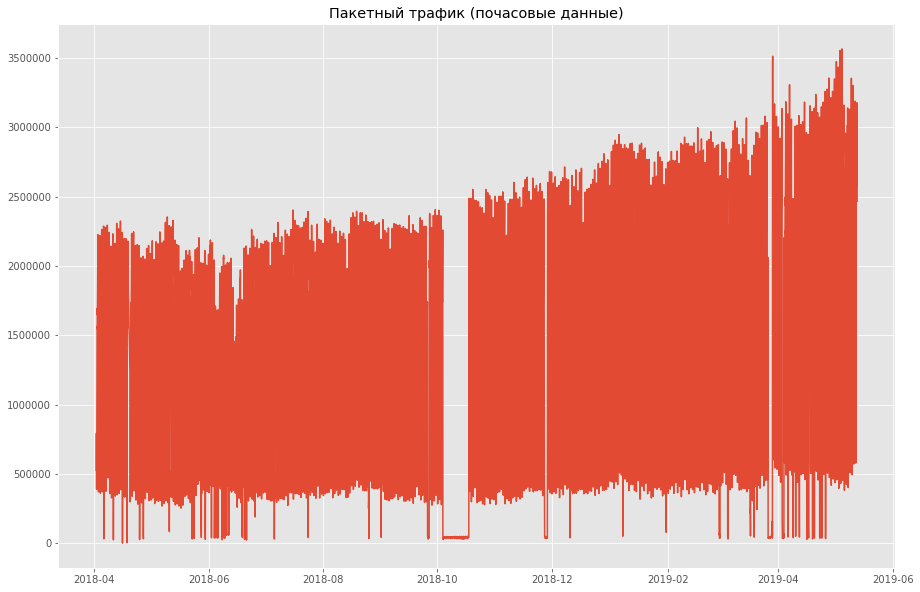

In [49]:
plt.figure(figsize=(15,10))
plt.plot(df_model.kpi)
plt.title('Пакетный трафик (почасовые данные)')
plt.grid(True)
plt.show()

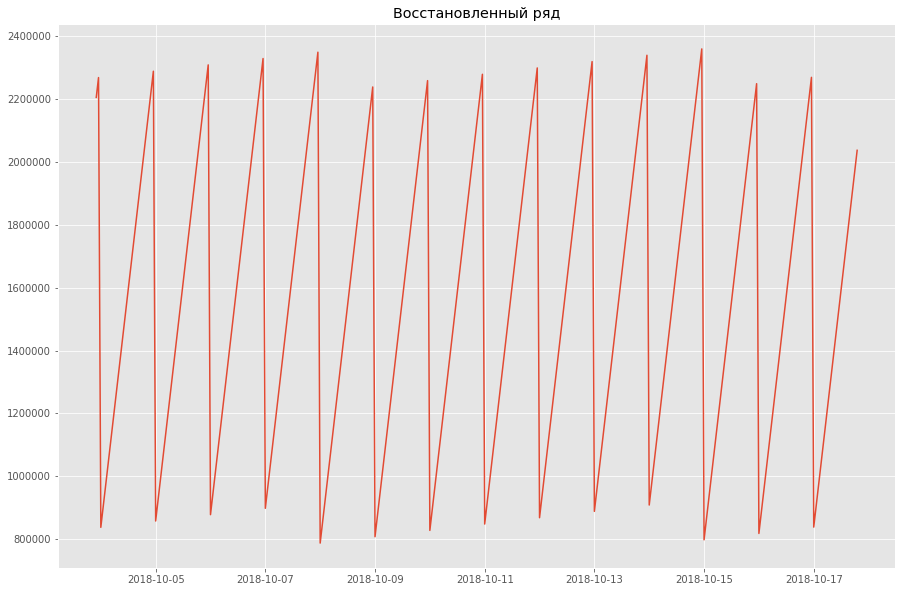

In [50]:
# Сначала восстановим с помощью регрессии
missing_kto = df_model[(df_model.date < '2018-10-03 22:00:00')]
missing_kto.kpi = missing_kto.kpi.mask(missing_kto.kpi <= 200000)
missing_kto.kpi = missing_kto.kpi.interpolate(method='linear')

# Берём данные за время КТО
missing_dates = df_model[(df_model.date >= '2018-10-03 22:00:00')&(df_model.date <= '2018-10-17 19:00:00')]

# С помощью регрессии прогнозируем, какие будет значения в этот период
tscv = TimeSeriesSplit(n_splits=5)

lasso = LassoCV(cv=tscv)
lasso.fit(missing_kto.dropna().drop(['kpi','date','2G','3G','4G'], axis=1), missing_kto.dropna().kpi)

missing_dates['kpi'] = lasso.predict(missing_dates.dropna().drop(['kpi','date','2G','3G','4G'], axis=1))

# Смотрим на Восстановленный ряд
plt.figure(figsize=(15,10))
plt.plot(missing_dates.kpi)
plt.title('Восстановленный ряд')
plt.grid(True)
plt.show()
df_model.loc[(df_model.date >= '2018-10-03 22:00:00')&(df_model.date <= '2018-10-17 19:00:00'),
          'kpi'] = missing_dates.kpi

## Восстановим с помощью модели Хольта-Уинтерса

In [51]:
class HoltWinters:

    """
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
    https://fedcsis.org/proceedings/2012/pliks/118.pdf

    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)

    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96): # обязательные поля конструктора класса
        self.series = series # временной ряд
        self.slen = slen # длина сезона
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds # горизонт прогнозирования
        self.scaling_factor = scaling_factor # параметр для доверительных интервалов

    def initial_trend(self):# сглаживаем по длине сезона, т.е. 0:00 усредняется по всем значениям с 0:00
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen) # количество сезонов в исходном ряду
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])

                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 

            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])

                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])

            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])



def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Возвращает ошибки на кросс валидации  
        
        params - вектор параметров для оптимизации
        series - набор данных с временным рядом
        slen - длина сезона в модели Хольта-Уинтерса
    """
    # вектор ошибок
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # Количество фолдов для кросс валидации 
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
    # Возвращаем средний квадрат ошибки по вектору ошибок     
    return np.mean(np.array(errors))


0.0033497345212977203 0.001994083746175379 0.011986374721718374
CPU times: user 2min 5s, sys: 94.7 ms, total: 2min 5s
Wall time: 2min 5s


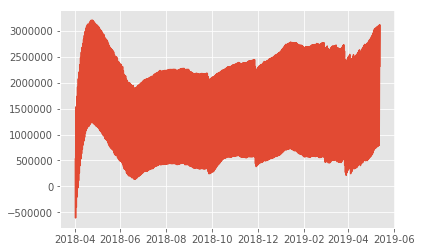

In [52]:
%%time
data = df_model['kpi'][:-24*7] # 7 дней для тестирования

# инициализируем параметры
x = [0, 0, 0] 

# Минимизируем функцию потерь с ограничениями на параметры 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Из оптимизатора берем оптимальное значение параметров...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...тренеруем с ними нашу модель и предсказываем на следующие 7 дней
model_holt = HoltWinters(data, slen = 24, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 24*7, scaling_factor = 2.5)
model_holt.triple_exponential_smoothing()
plt.plot(pd.DataFrame(data=model_holt.result, index=df_model[:len(model_holt.result)].index))

In [53]:
# к получившимся значениям цепляем индекс (даты) исходного ряда
missing_dates = pd.DataFrame(data={'kpi':model_holt.result}, index=df_model[:len(model_holt.result)].index)
# Заменяем значения в момент провала на значения, полученные моделью Хольта-Уинтерса
df_model.loc[(df_model.date >= '2018-10-03 22:00:00')&(df_model.date <= '2018-10-17 19:00:00'),
          'kpi'] = missing_dates.loc[(df_model.date >= '2018-10-03 22:00:00')&(df_model.date <= '2018-10-17 19:00:00'),
          'kpi']
# аномально низкие значения интерполируем
df_model.kpi = df_model.kpi.mask(df_model.kpi <= 200000)
df_model.kpi = df_model.kpi.interpolate(method='linear')


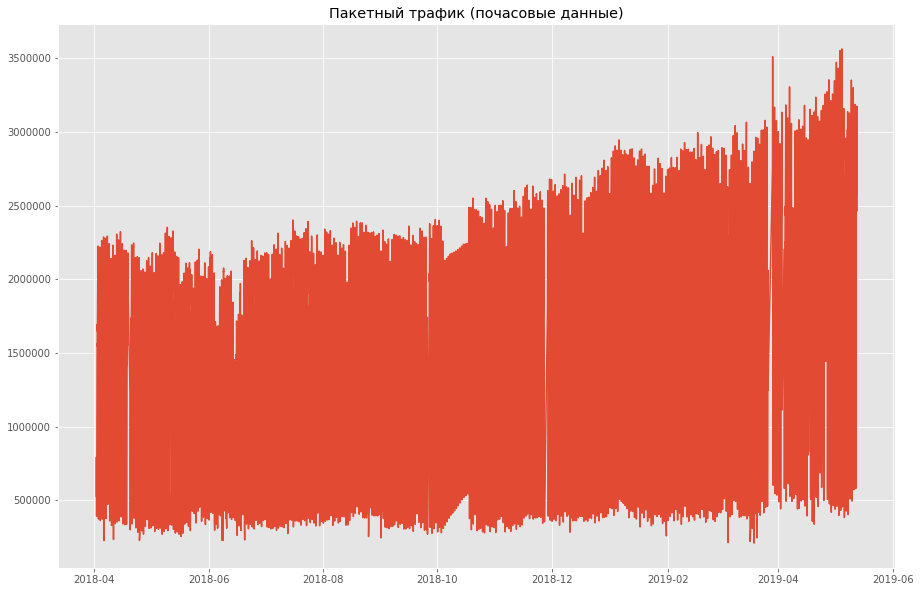

In [54]:
plt.figure(figsize=(15,10))
plt.plot(df_model.kpi)
plt.title('Пакетный трафик (почасовые данные)')
plt.grid(True)
plt.show()

In [55]:
# Берём данные по 6 региону - неизменённые 
data_real = df[df.Region == 6]
data_real = data_real[data_real.date >= '2018-04-01 00:00:00']
data_real.fillna(0,inplace=True)

## Визуализация данных

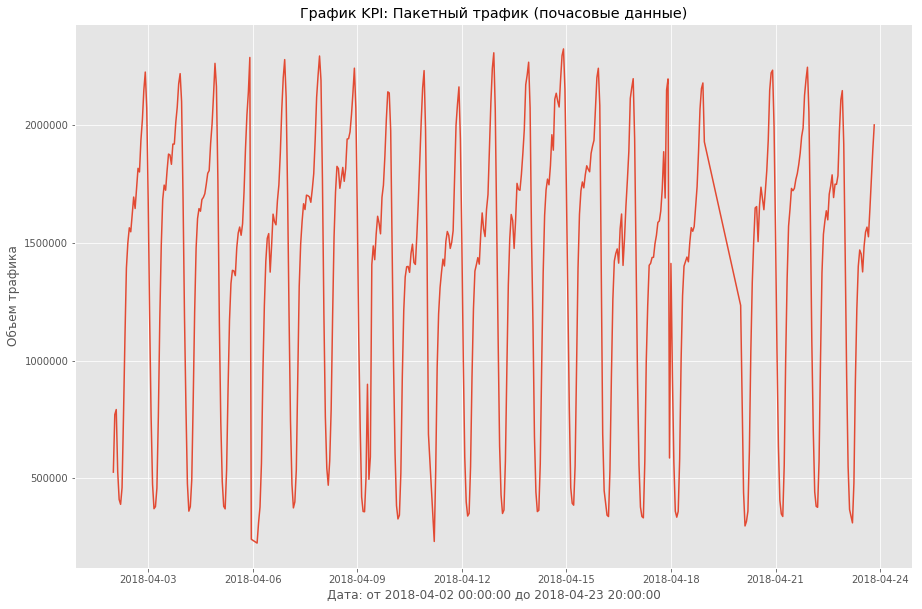

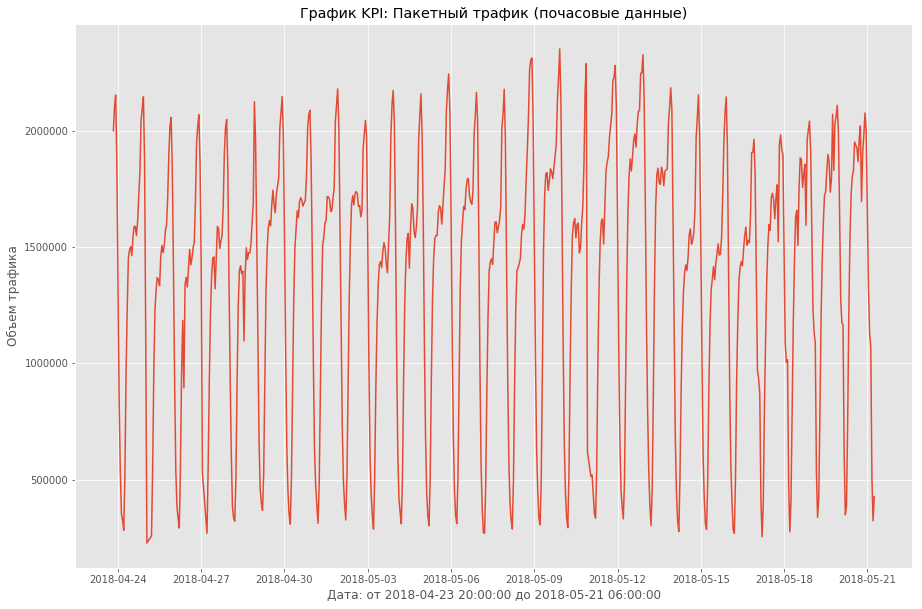

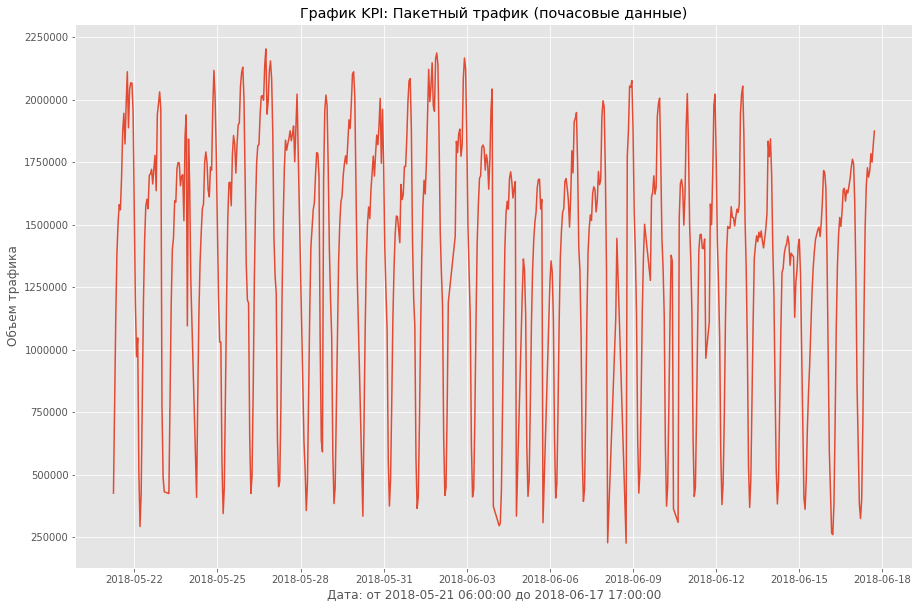

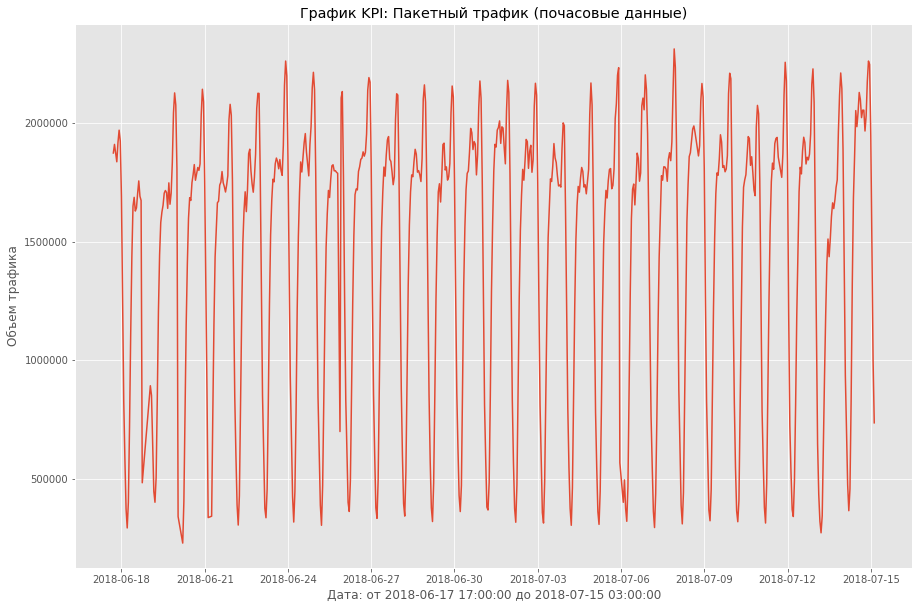

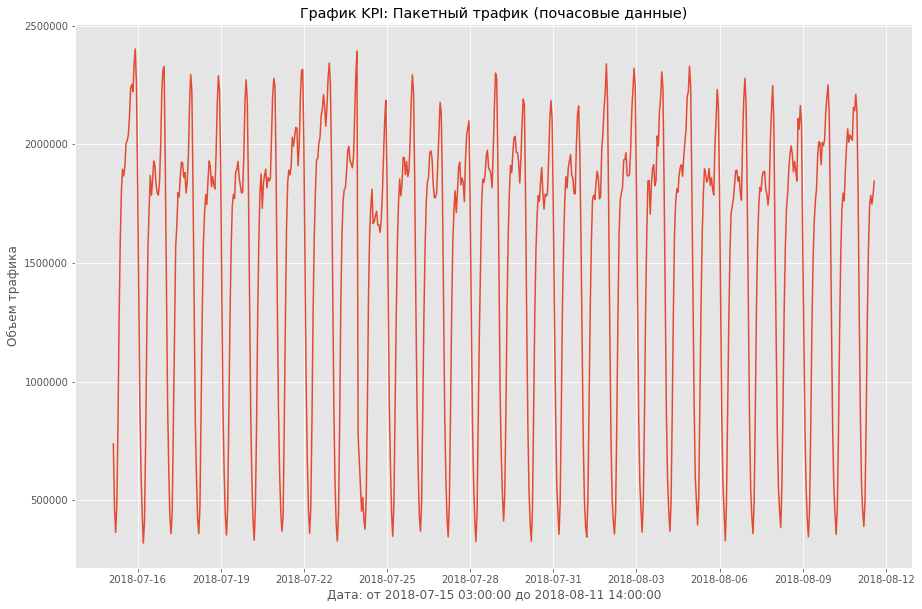

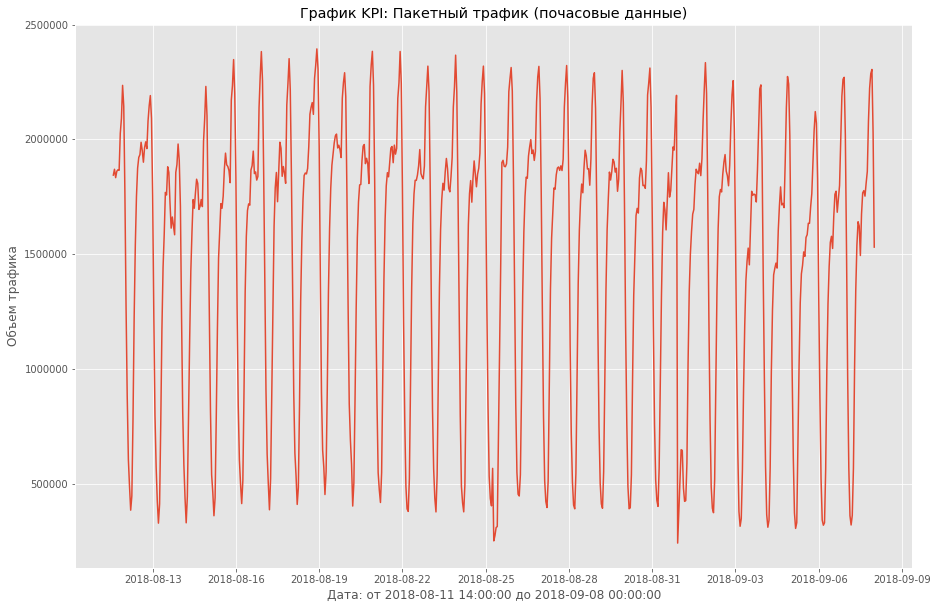

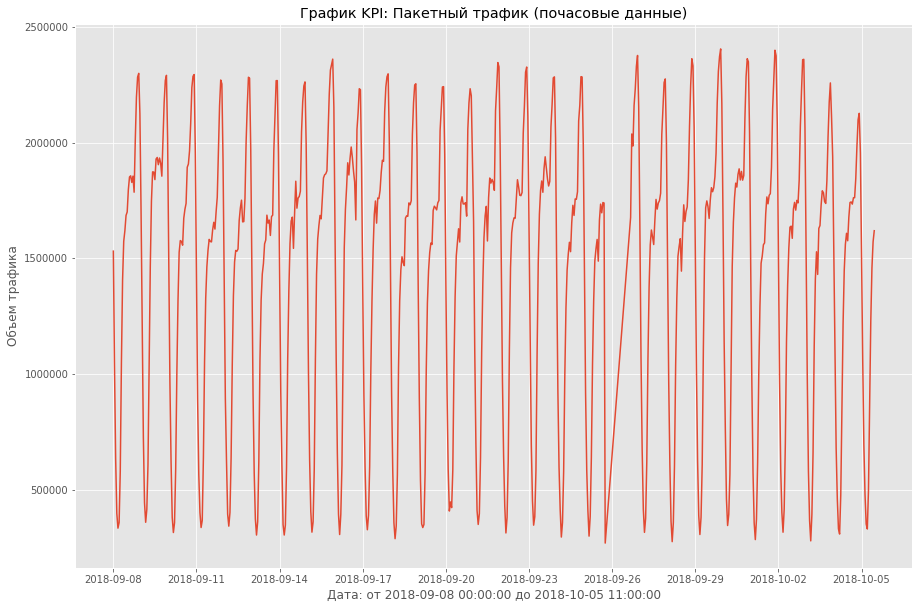

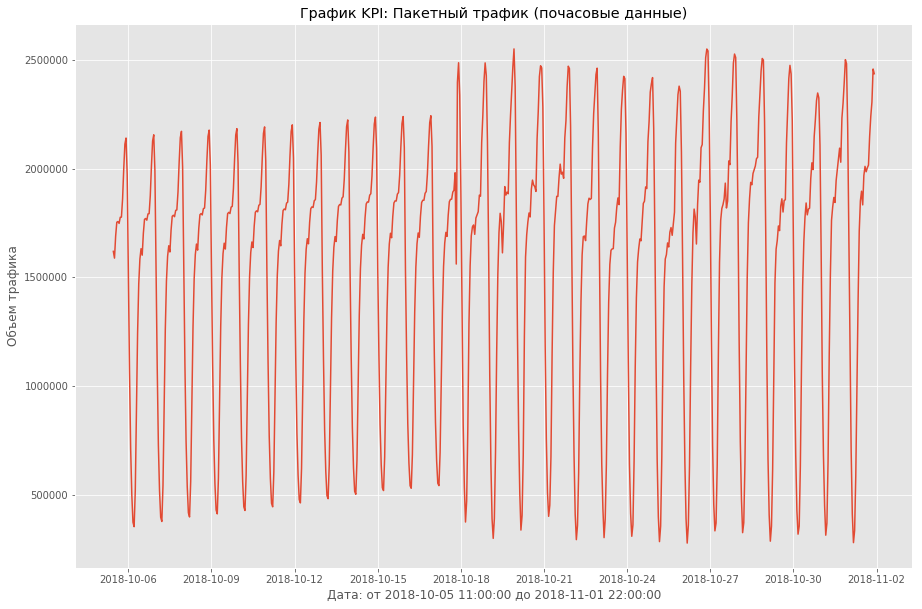

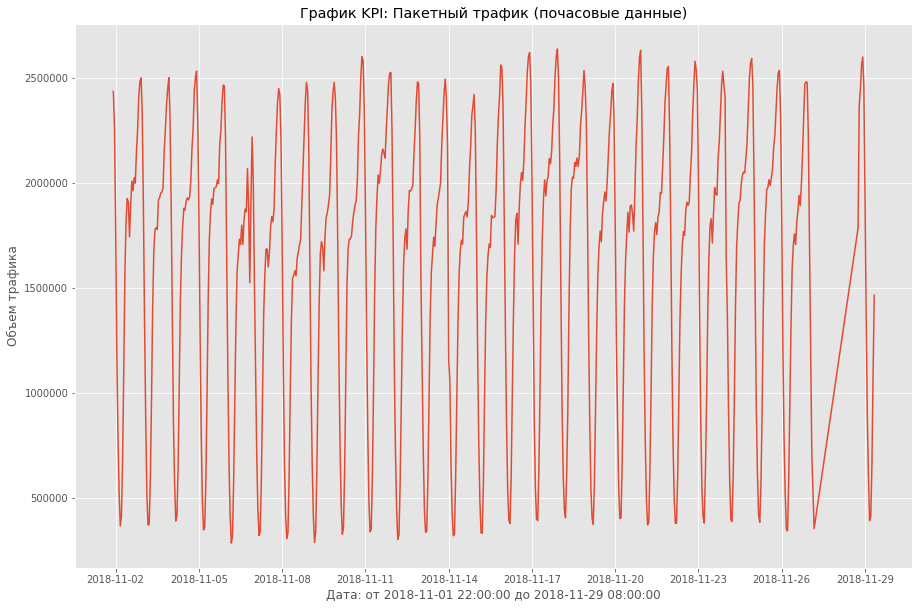

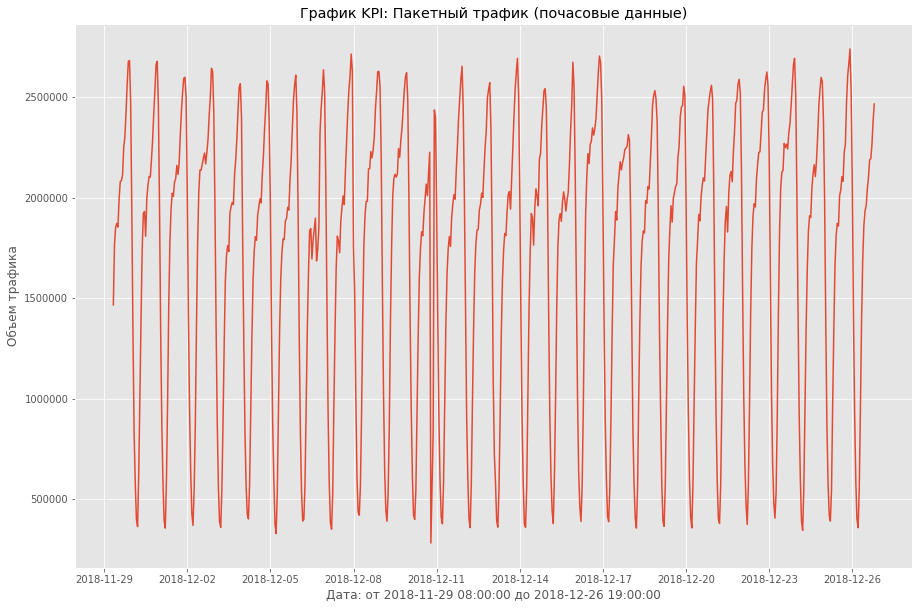

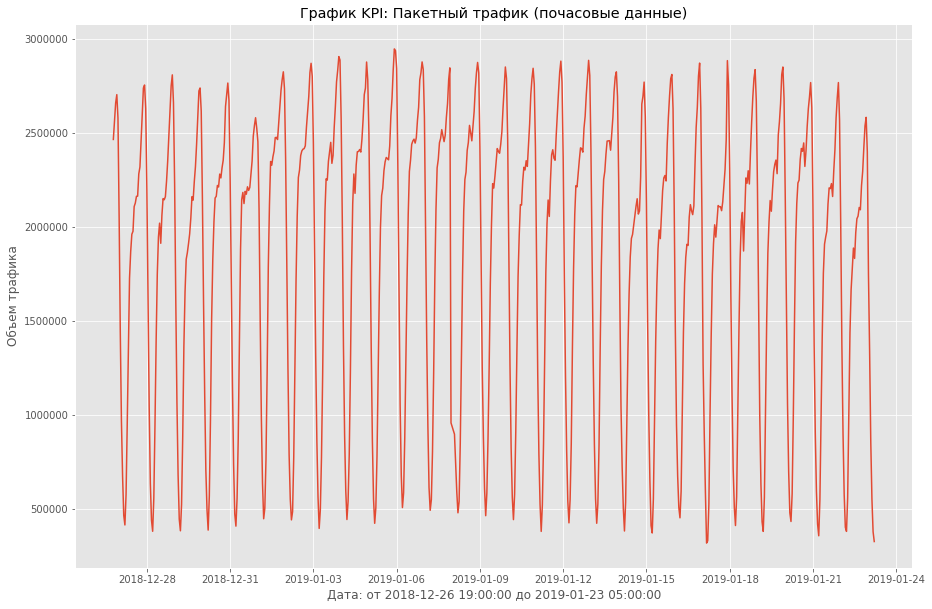

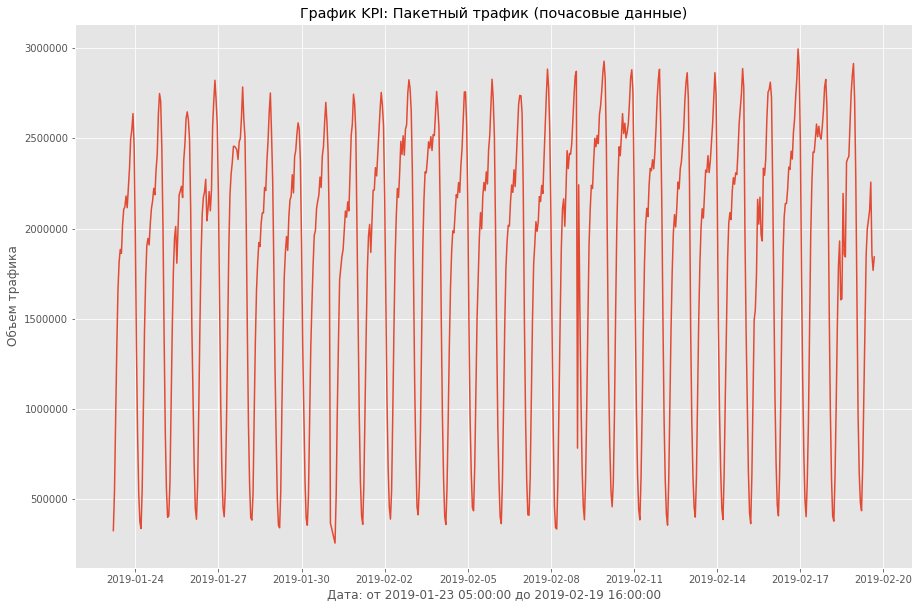

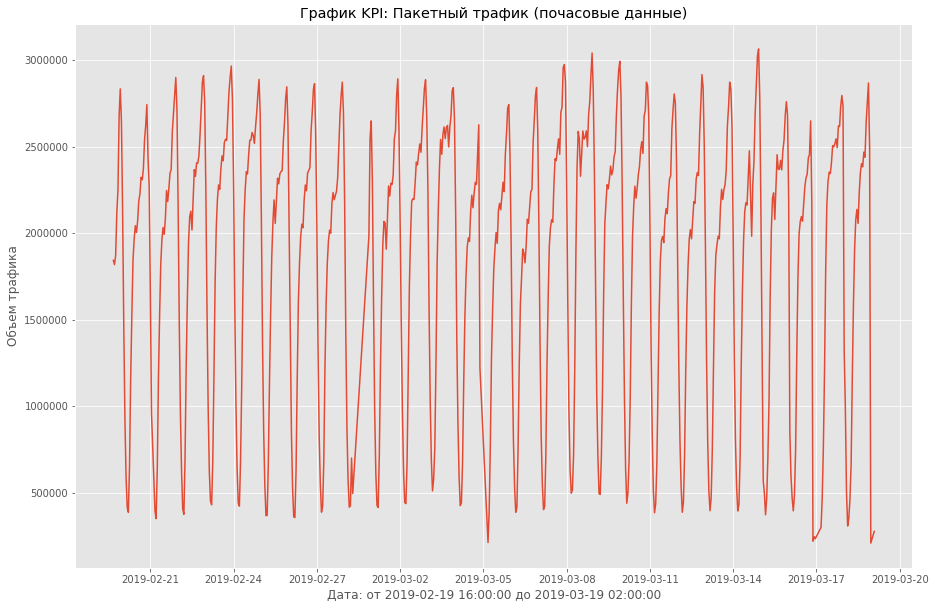

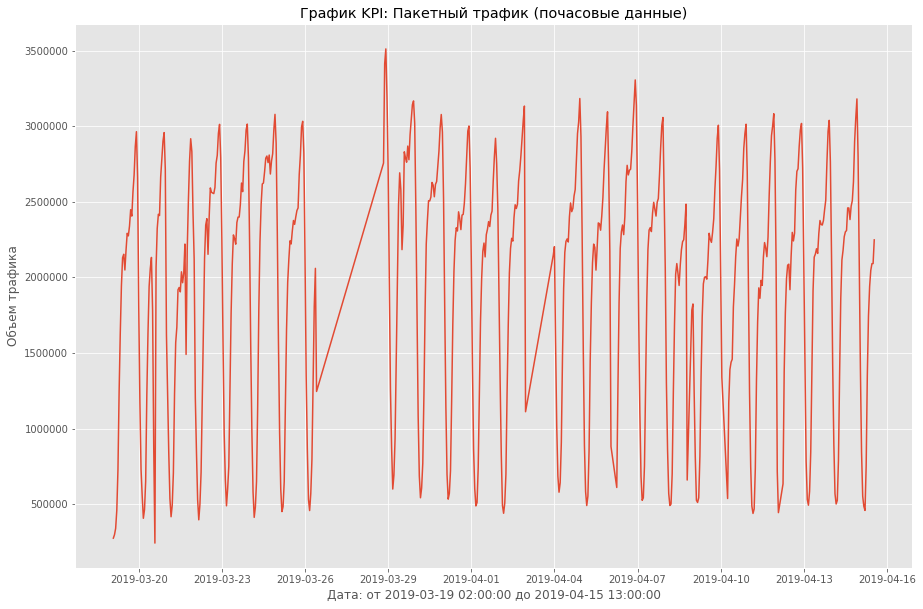

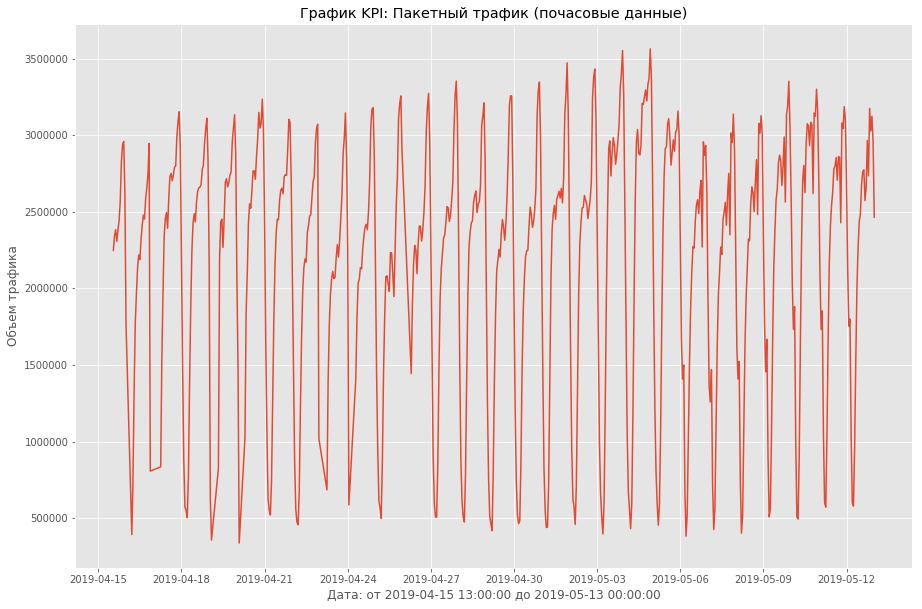

In [56]:
a = 0
for i in np.linspace(500,len(df_model)-1,15,dtype=int):    
    plt.figure(figsize=(15,10))
    plt.plot(df_model[(df_model.index[a] <= df_model.date) & (df_model.date <= df_model.index[i])].kpi)
    plt.grid(True)
    plt.title('График KPI: Пакетный трафик (почасовые данные)')
    plt.ylabel('Объем трафика')
    plt.xlabel('Дата: от {} до {}'.format(df_model.index[a],df_model.index[i]))
    plt.show()
    a = i

In [57]:
# Создаём метрику MAPE - средняя абсолютная ошибка в %

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Построение моделей

### Экспоненциальное сглаживание

In [58]:
%%time
data = df_model['kpi'][:-24*7] # 7 дней для тестирования

# инициализируем параметры
x = [0, 0, 0] 

# Минимизируем функцию потерь с ограничениями на параметры 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Из оптимизатора берем оптимальное значение параметров...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0.003069407442729599 0.0024346253135941742 0.02046378182157932
CPU times: user 2min 1s, sys: 18.3 ms, total: 2min 1s
Wall time: 2min 1s


In [59]:
# ...тренеруем с ними нашу модель и предсказываем на следующие 7 дней
model_holt = HoltWinters(data, slen = 24, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 24*7, scaling_factor = 2.5)
model_holt.triple_exponential_smoothing()

In [60]:
# Функция для отрисовки результата работы модели Хольта-Уинтерса
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - временной ряд
        plot_intervals - показывать ли доверительные интервалы
        plot_anomalies - показывать ли аномалии
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model_holt.result, label = "Модель")
    plt.plot(series.values, label = "Данные")
    error = mean_absolute_percentage_error(series.values, model_holt.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model_holt.LowerBond[:len(series)]] = \
            series.values[series.values<model_holt.LowerBond[:len(series)]]
        anomalies[series.values>model_holt.UpperBond[:len(series)]] = \
            series.values[series.values>model_holt.UpperBond[:len(series)]]
        plt.plot(anomalies, ".", markersize=10,color = 'r', label = "Аномалии")
    
    if plot_intervals:
        plt.plot(model_holt.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model_holt.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model_holt.result)), y1=model_holt.UpperBond, 
                         y2=model_holt.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model_holt.LowerBond), ymax=max(model_holt.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model_holt.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);
    

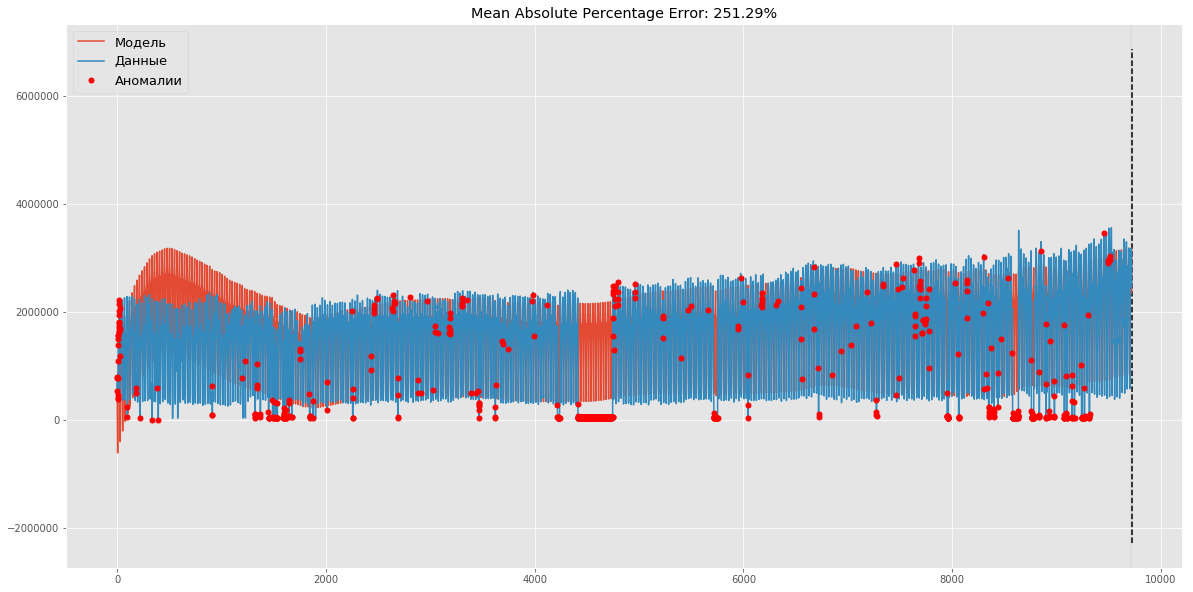

In [61]:
#plotHoltWinters(data_real.kpi)
plotHoltWinters(data_real.kpi, plot_intervals=False, plot_anomalies=True)

In [73]:
%%time
# формируем первичный список аномалий,в который попадают все отклонения
anomalies = np.array([np.NaN]*len(df_model.kpi))
anomalies[df_model.kpi.values<model_holt.LowerBond[:len(df_model.kpi)]] = \
df_model.kpi.values[df_model.kpi.values<model_holt.LowerBond[:len(df_model.kpi)]]
anomalies[df_model.kpi.values>model_holt.UpperBond[:len(df_model.kpi)]] = \
df_model.kpi.values[df_model.kpi.values>model_holt.UpperBond[:len(df_model.kpi)]]
anomalies = pd.DataFrame(anomalies,df_model.date)


for i in np.linspace(2,4,5):
    model_holt = HoltWinters(data_real.kpi, slen = 24, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 24*7, scaling_factor = i)
    model_holt.triple_exponential_smoothing()
    anomalies_holt = np.array([np.NaN]*len(df_model.kpi))
    anomalies_holt[df_model.kpi.values<model_holt.LowerBond[:len(df_model.kpi)]] = \
                df_model.kpi.values[df_model.kpi.values<model_holt.LowerBond[:len(df_model.kpi)]]
    anomalies_holt[df_model.kpi.values>model_holt.UpperBond[:len(df_model.kpi)]] = \
                df_model.kpi.values[df_model.kpi.values>model_holt.UpperBond[:len(df_model.kpi)]]
    anomalies_holt = pd.DataFrame(anomalies_holt,df_model.date)
    anomalies['{}'.format(i)] = anomalies_holt
anomalies.dropna(how = 'all',inplace=True)
anomalies['date'] = pd.to_datetime(anomalies.index, format='%Y-%m-%d %H:%M:%S')
anomalies['hour'] = anomalies['date'].dt.hour # час
anomalies['date'] = anomalies['date'].dt.strftime('%d.%m.%Y') 
#anomalies.to_csv('anomalies_holt_ingush.csv')

CPU times: user 5.21 s, sys: 26.6 ms, total: 5.24 s
Wall time: 5.24 s


In [63]:
anomalies.tail(100)

0          2.0          2.5          3.0  \
date                                                                      
2019-03-24 13:00:00          nan 2699730.2628          nan          nan   
2019-03-24 14:00:00          nan 2788894.0741          nan          nan   
2019-03-24 15:00:00          nan 2803020.6942          nan          nan   
2019-03-26 10:00:00 1246277.4841 1246277.4841 1246277.4841 1246277.4841   
2019-03-26 11:00:00 1272318.5731 1272318.5731 1272318.5731 1272318.5731   
2019-03-26 12:00:00 1298359.6621 1298359.6621 1298359.6621          nan   
2019-03-26 13:00:00 1324400.7511 1324400.7511          nan          nan   
2019-03-26 14:00:00 1350441.8401 1350441.8401          nan          nan   
2019-03-26 15:00:00 1376482.9291 1376482.9291          nan          nan   
2019-03-26 16:00:00 1402524.0181          nan          nan          nan   
2019-03-26 17:00:00 1428565.1071          nan          nan          nan   
2019-03-26 18:00:00 1454606.1961          nan          nan          nan   
2019-03-26 19:00:00 1480647.2852          nan          nan          nan   
2019-03-26 20:00:00 1506688.3742          nan          nan          nan   
2019-03-26 21:00:00 1532729.4632          nan          nan          nan   
2019-03-26 22:00:00 1558770.5522          nan          nan          nan   
2019-03-27 03:00:00 1688975.9972          nan          nan          nan   
2019-03-27 04:00:00 1715017.0862          nan          nan          nan   
2019-03-27 05:00:00 1741058.1752          nan          nan          nan   
2019-03-28 02:00:00 2287921.0444          nan          nan          nan   
2019-03-28 03:00:00 2313962.1334          nan          nan          nan   
2019-03-28 04:00:00 2340003.2224 2340003.2224          nan          nan   
2019-03-28 05:00:00 2366044.3114 2366044.3114          nan          nan   
2019-03-28 06:00:00 2392085.4004          nan          nan          nan   
2019-04-02 23:00:00 1112324.9196 1112324.9196          nan          nan   
2019-04-03 00:00:00 1155440.9688          nan          nan          nan   
2019-04-03 04:00:00 1327905.1657          nan          nan          nan   
2019-04-03 05:00:00 1371021.2150 1371021.2150          nan          nan   
2019-04-06 01:00:00  881885.8540          nan          nan          nan   
2019-04-06 23:00:00 3136904.4721          nan          nan          nan   
...                          ...          ...          ...          ...   
2019-05-02 21:00:00          nan 3383155.9047          nan          nan   
2019-05-02 22:00:00          nan 3432713.0592          nan          nan   
2019-05-02 23:00:00          nan 3120532.9391          nan          nan   
2019-05-03 10:00:00 2911958.2057 2911958.2057 2911958.2057 2911958.2057   
2019-05-03 11:00:00 2963384.1590 2963384.1590 2963384.1590 2963384.1590   
2019-05-03 12:00:00          nan 2734278.3159          nan          nan   
2019-05-03 13:00:00          nan 2889011.1681          nan          nan   
2019-05-03 14:00:00          nan 2984467.9657          nan          nan   
2019-05-03 15:00:00          nan 2933699.4461          nan          nan   
2019-05-03 22:00:00          nan 3553750.0147          nan          nan   
2019-05-03 23:00:00          nan 3269039.5986          nan          nan   
2019-05-04 10:00:00 2959186.6359 2959186.6359 2959186.6359          nan   
2019-05-04 11:00:00 3037674.8932 3037674.8932 3037674.8932          nan   
2019-05-04 12:00:00          nan 2883008.8005          nan          nan   
2019-05-04 15:00:00          nan 3208241.0741          nan          nan   
2019-05-04 16:00:00          nan 3201413.7377          nan          nan   
2019-05-04 17:00:00          nan 3254434.3545          nan          nan   
2019-05-04 18:00:00          nan 3296070.5764          nan          nan   
2019-05-06 03:00:00          nan 1499542.9471          nan          nan   
2019-05-07 03:00:00          nan 1469190.8523          nan          nan   
2019-05-08 03:00:00          nan 1523210.4247 1523210.42

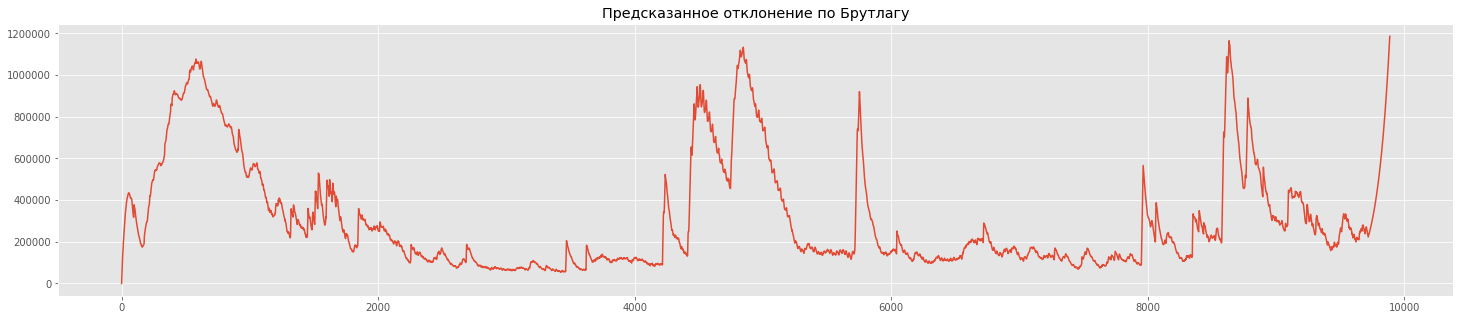

In [64]:
plt.figure(figsize=(25, 5))
plt.plot(model_holt.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Предсказанное отклонение по Брутлагу");

## Линейные модели

### Формируем обучающую и тестовую выборку
#### Функция, собирающая тестовую и тренировочную выборки

In [65]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, в котором ключи являются уникальными категориями cat_feature,
    а значения средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

def timeseries_train_test_split(X, y, test_size, n_splits=5):
    """
        выполняем разбиение на обучающую и тестовую выборки
    """
    
    # устанавливаем количество фолдов на кросс-валидации
    tscv = TimeSeriesSplit(n_splits=n_splits)
    # получаем индекс, после которого начинается тестовая выборка
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

def prepareData(series, lag_start, lag_end, test_size=0.3, target_encoding=False, column_drop = False, drop_names = ('y')):
    """
        series: pd.DataFrame 
            данные с временным рядом
        lag_start: int
            начальный шаг назад во времени для среза по целевой переменной 
            Например - lag_start = 1 означает, что модель увидит вчерашние значения, чтобы предсказать сегодня
        lag_end: int
            насколько далеко назад мы зайдём
            example - lag_end = 4 будем использовать данные за 4 шага, чтобы предсказывать нынешние значения 
        test_size: float
            размер тостового датасета в процентах (десятичн)
        target_encoding: boolean
            if True - добавляем средние значения целевой переменной как доп факторы
        
    """
    
    # копируем заданные данные
    data = series.copy()
    data.rename(index=str, columns={'kpi':'y'},inplace=True)
    
    # лаги ряда
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    data["lag_{}".format('week')] = data.y.shift(24*7)
    
    # Создаём временные переменные
    data['date'] = pd.to_datetime(data.index)
    data['hour'] = data['date'].dt.hour
    data['dayofweek'] = data['date'].dt.dayofweek
    data['quarter'] = data['date'].dt.quarter
    data['month'] = data['date'].dt.month
    data['year'] = data['date'].dt.year
    data['dayofyear'] = data['date'].dt.dayofyear
    data['dayofmonth'] = data['date'].dt.day
    data['weekofyear'] = data['date'].dt.weekofyear
    data['is_weekend'] = data.dayofweek.isin([5,6])*1
    data.drop(['date'],axis = 1,inplace=True)
    
    # Перекодирование переменных
    if target_encoding:
        # высчитываем средние на тренировочных данных
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(
            code_mean(data[:test_index], 'dayofweek', "y").get, data.dayofweek))
        data["hour_average"] = list(map(
            code_mean(data[:test_index], 'hour', "y").get, data.hour))
        data["month_average"] = list(map(
            code_mean(data[:test_index], 'month', "y").get, data.hour))

        # удаляем столбцы, которые перекодировали 
#        data.drop(["hour", "dayofweek","month"], axis=1, inplace=True)
    
    # разбиваем выборку на тренировочную и тестовую
    if column_drop: 
            y = data.fillna(0).y
            for i in (drop_names):
                X = data.fillna(0).drop(['{}'].format(i), axis=1)
            X_train, X_test, y_train, y_test =\
            timeseries_train_test_split(X, y, test_size=test_size)
    else: 
        y = data.fillna(0).y
        X = data.fillna(0).drop(['y'], axis=1)
        X_train, X_test, y_train, y_test =\
        timeseries_train_test_split(X, y, test_size=test_size)
        
    return X_train, X_test, y_train, y_test

In [66]:
# Создаём выборки
X_train, X_test, y_train, y_test =\
prepareData(df_model, lag_start=1, lag_end=25, test_size=0.3)

#### Функции для отрисовки графика с прогнозом и аномалиями + график значимости переменных

In [67]:
# График модельных и предсказанных данных с выделением аномалий
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False, scale = 2.5):
    """
        График модельных и фактических значений с интервалами предсказания и аномалиями
    
    """
    # предсказываем будущие значения
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="Предсказанные значения", linewidth=2.0)
    plt.plot(y_test.values, label="Реальные значения", linewidth=2.0)
    cv = cross_val_score(model, X_train, y_train,
                         cv=tscv, 
                         scoring="neg_mean_squared_error")
    #mae = cv.mean() * (-1)
    deviation = np.sqrt(cv.std()) # Стандартное отклонение
    
    lower = prediction - (scale * deviation)
    upper = prediction + (scale * deviation)
    
    if plot_intervals:
        plt.plot(lower, "r--", label="Верхняя граница / Нижняя граница", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(y_test))
        anomalies[y_test<lower] = y_test[y_test<lower]
        anomalies[y_test>upper] = y_test[y_test>upper]
        plt.plot(anomalies, ".", markersize=10, label = "Аномалии")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Графики отсортированных значений коэффициентов модели
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

#### Линейная регрессия

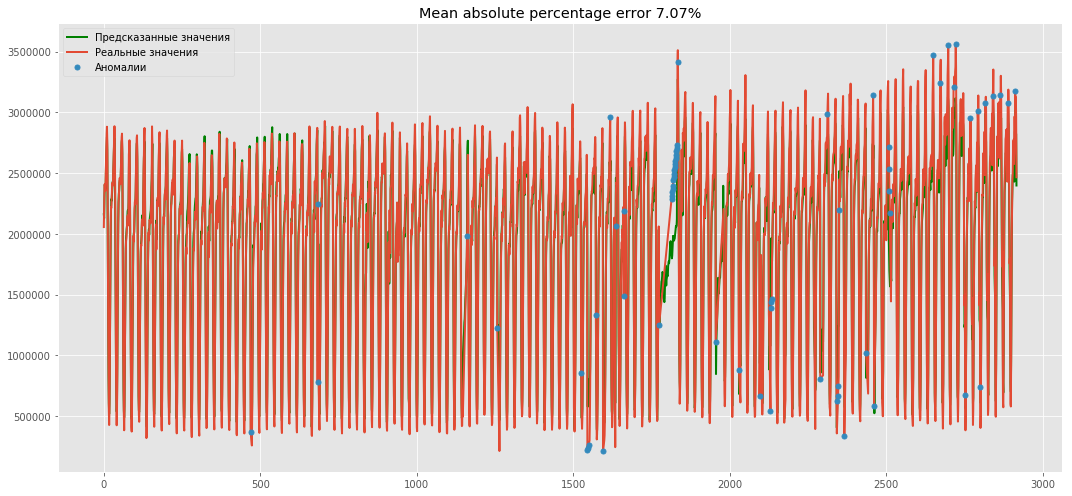

In [74]:

# Простая линейная регрессия
lr = LinearRegression()
lr.fit(X_train, y_train)

plotModelResults(lr,X_train=X_train,X_test=X_test, plot_intervals=False,plot_anomalies=True,scale =3.5)
#plotCoefficients(lr)

#### Собираем аномальные значения.

In [83]:
%%time
scale = 3.5
prediction = lr.predict(X_test)
cv = cross_val_score(lr, X_train, y_train,cv=tscv, scoring="neg_mean_squared_error")
deviation = np.sqrt(cv.std()) # Стандартное отклонение
lower = prediction - (scale * deviation)
upper = prediction + (scale * deviation)  
anomalies = np.array([np.NaN]*len(y_test))
anomalies[y_test<lower] = y_test[y_test<lower]
anomalies[y_test>upper] = y_test[y_test>upper]
anomalies = pd.DataFrame(anomalies,y_test.index)

for scale in np.linspace(3.5,3.75,5):
    cv = cross_val_score(lr, X_train, y_train,
                         cv=tscv, 
                         scoring="neg_mean_squared_error")
    deviation = np.sqrt(cv.std()) # Стандартное отклонение
    lower = prediction - (scale * deviation)
    upper = prediction + (scale * deviation)
    
    anomalies_lin = np.array([np.NaN]*len(y_test))
    anomalies_lin[y_test<lower] = y_test[y_test<lower]
    anomalies_lin[y_test>upper] = y_test[y_test>upper]
    anomalies['{}'.format(scale)] = anomalies_lin
anomalies.dropna(how = 'all',inplace=True)
anomalies['date'] = pd.to_datetime(anomalies.index, format='%Y-%m-%d %H:%M:%S')
anomalies['hour'] = anomalies['date'].dt.hour # час
anomalies['date'] = anomalies['date'].dt.strftime('%d.%m.%Y') 
#anomalies.to_csv('anomalies_lin_ingush.csv')

CPU times: user 4.14 s, sys: 21.8 s, total: 26 s
Wall time: 820 ms


In [84]:
anomalies

0          3.5       3.5625        3.625  \
Дата со временем                                                          
2019-01-31 01:00:00  368097.4397  368097.4397  368097.4397  368097.4397   
2019-02-08 23:00:00  783212.0864  783212.0864  783212.0864  783212.0864   
2019-02-09 00:00:00 2242621.8050 2242621.8050 2242621.8050 2242621.8050   
2019-02-28 21:00:00 1984900.3874 1984900.3874 1984900.3874 1984900.3874   
2019-03-04 21:00:00 1224260.1995 1224260.1995 1224260.1995 1224260.1995   
2019-03-16 01:00:00  854109.9622  854109.9622  854109.9622  854109.9622   
2019-03-16 21:00:00  219296.7568  219296.7568  219296.7568  219296.7568   
2019-03-16 23:00:00  233228.9212  233228.9212  233228.9212  233228.9212   
2019-03-17 01:00:00  259803.9511  259803.9511  259803.9511  259803.9511   
2019-03-18 00:00:00 1327540.5949 1327540.5949 1327540.5949 1327540.5949   
2019-03-18 23:00:00  208380.5744  208380.5744  208380.5744  208380.5744   
2019-03-19 22:00:00 2964132.2803 2964132.2803 2964132.2803          nan   
2019-03-20 15:00:00 2066458.5664 2066458.5664 2066458.5664 2066458.5664   
2019-03-21 17:00:00 1491105.3901 1491105.3901 1491105.3901 1491105.3901   
2019-03-21 18:00:00 2185896.5339 2185896.5339          nan          nan   
2019-03-26 10:00:00 1246277.4841 1246277.4841 1246277.4841 1246277.4841   
2019-03-28 02:00:00 2287921.0444 2287921.0444 2287921.0444 2287921.0444   
2019-03-28 03:00:00 2313962.1334 2313962.1334 2313962.1334 2313962.1334   
2019-03-28 04:00:00 2340003.2224 2340003.2224 2340003.2224 2340003.2224   
2019-03-28 05:00:00 2366044.3114 2366044.3114 2366044.3114 2366044.3114   
2019-03-28 06:00:00 2392085.4004 2392085.4004 2392085.4004 2392085.4004   
2019-03-28 08:00:00 2444167.5784 2444167.5784 2444167.5784 2444167.5784   
2019-03-28 09:00:00 2470208.6674 2470208.6674 2470208.6674 2470208.6674   
2019-03-28 10:00:00 2496249.7565 2496249.7565 2496249.7565 2496249.7565   
2019-03-28 11:00:00 2522290.8455 2522290.8455 2522290.8455 2522290.8455   
2019-03-28 12:00:00 2548331.9345 2548331.9345 2548331.9345 2548331.9345   
2019-03-28 13:00:00 2574373.0235 2574373.0235 2574373.0235 2574373.0235   
2019-03-28 14:00:00 2600414.1125 2600414.1125 2600414.1125 2600414.1125   
2019-03-28 15:00:00 2626455.2015 2626455.2015 2626455.2015 2626455.2015   
2019-03-28 16:00:00 2652496.2905 2652496.2905 2652496.2905 2652496.2905   
...                          ...          ...          ...          ...   
2019-04-10 09:00:00 1439640.7354 1439640.7354 1439640.7354 1439640.7354   
2019-04-10 10:00:00 1459347.7909 1459347.7909 1459347.7909 1459347.7909   
2019-04-16 21:00:00  806996.2103  806996.2103  806996.2103  806996.2103   
2019-04-17 20:00:00 2987459.0008 2987459.0008 2987459.0008 2987459.0008   
2019-04-19 01:00:00  622911.5198  622911.5198  622911.5198  622911.5198   
2019-04-19 06:00:00  668330.9366  668330.9366  668330.9366  668330.9366   
2019-04-19 07:00:00  746250.3148  746250.3148  746250.3148  746250.3148   
2019-04-19 09:00:00 2194426.9385 2194426.9385 2194426.9385 2194426.9385   
2019-04-20 02:00:00  336861.9280  336861.9280  336861.9280  336861.9280   
2019-04-22 23:00:00 1020650.9506 1020650.9506 1020650.9506 1020650.9506   
2019-04-23 22:00:00 3146335.5253 3146335.5253 3146335.5253 3146335.5253   
2019-04-24 01:00:00  586171.6965  586171.6965  586171.6965  586171.6965   
2019-04-26 00:00:00 2716284.8749 2716284.8749 2716284.8749 2716284.8749   
2019-04-26 01:00:00 2534427.1164 2534427.1164 2534427.1164 2534427.1164   
2019-04-26 02:00:00 2352569.3580 2352569.3580 2352569.3580 2352569.3580   
2019-04-26 03:00:00 2170711.5996 2170711.5996 2170711.5996 2170711.5996   
2019-05-01 22:00:00 3472919.8915 3472919.8915 3472919.8915 3472919.8915   
2019-05-02 20:00:00 3242673.2466 3242673.2466 3242673.2466 3242673.2466   
2019-05-03 22:00:00 3553750.0147 3553750.0147 3553750.0147          nan   
2019-05-04 15:00:00 3208241.0741 3208241.0741 3208241.0741 3208241.0741   
2019-05-04 22:00:00 3564200.2962 3564200.2962 3564200.29

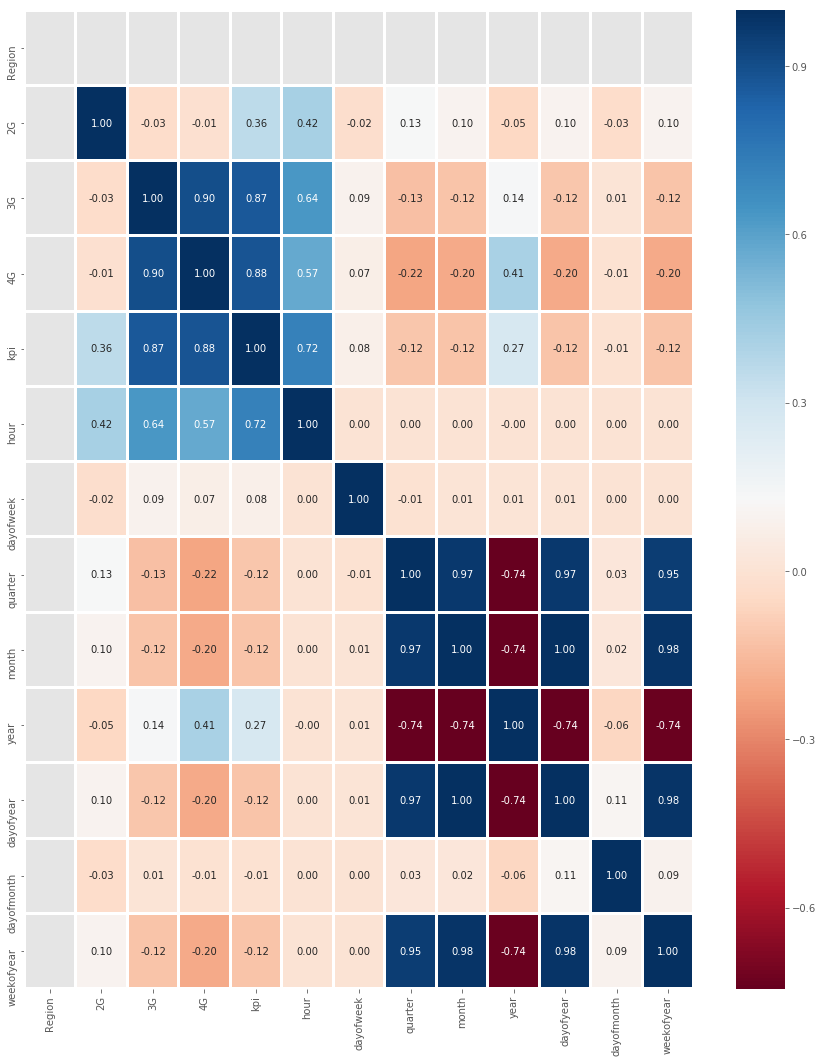

In [85]:
corr_matrix = df_model.corr(method = 'pearson')
f,ax = plt.subplots(figsize = (15,18))
sns.heatmap(corr_matrix, annot = True, fmt = '.2f', linewidths = 2, cmap = 'RdBu')

#### (Гребневая) Ридж-регрессия 

In [86]:
# Приводим данные к одной шкале
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Строим модель
ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
    cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
    fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

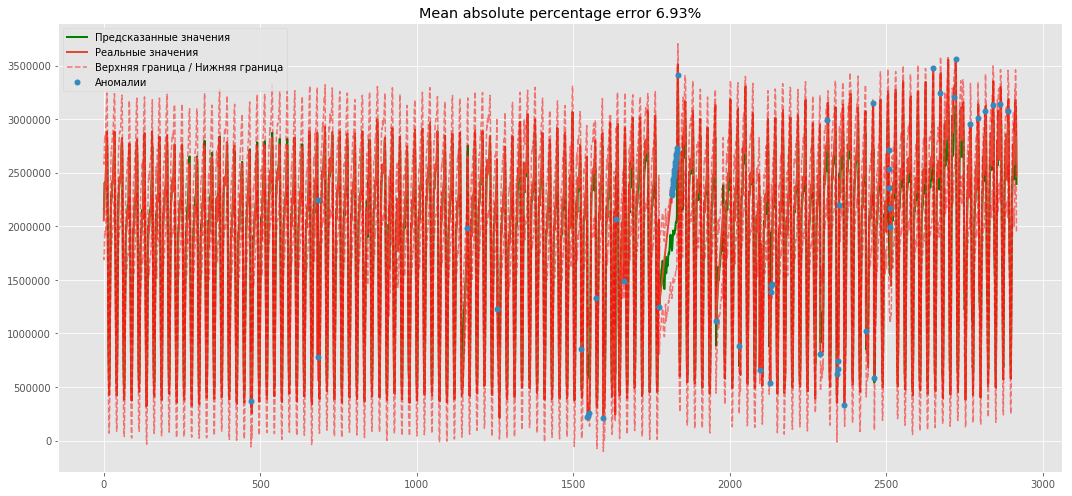

In [93]:
# График модели с выделением аномальных объектов
plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True, scale = 3.375)
#plotCoefficients(ridge)

In [88]:
%%time
scale = 3.375 
prediction = ridge.predict(X_test_scaled)
cv = cross_val_score(ridge, X_train, y_train,cv=tscv, scoring="neg_mean_squared_error")
deviation = np.sqrt(cv.std()) # Стандартное отклонение
lower = prediction - (scale * deviation)
upper = prediction + (scale * deviation)  
anomalies = np.array([np.NaN]*len(y_test))

anomalies[y_test<lower] = y_test[y_test<lower]
anomalies[y_test>upper] = y_test[y_test>upper]
anomalies = pd.DataFrame(anomalies,y_test.index)

for scale in np.linspace(3.375,3.5,3):
    cv = cross_val_score(ridge, X_train, y_train,
                         cv=tscv, 
                         scoring="neg_mean_squared_error")
    deviation = np.sqrt(cv.std()) # Стандартное отклонение
    lower = prediction - (scale * deviation)
    upper = prediction + (scale * deviation)
    
    anomalies_ridge = np.array([np.NaN]*len(y_test))
    anomalies_ridge[y_test<lower] = y_test[y_test<lower]
    anomalies_ridge[y_test>upper] = y_test[y_test>upper]
    anomalies['{}'.format(scale)] = anomalies_ridge
anomalies.dropna(how = 'all',inplace=True)
anomalies['date'] = pd.to_datetime(anomalies.index, format='%Y-%m-%d %H:%M:%S')
anomalies['hour'] = anomalies['date'].dt.hour # час
anomalies['date'] = anomalies['date'].dt.strftime('%d.%m.%Y')    
#anomalies.to_csv('anomalies_ridge_ingush.csv')

CPU times: user 20.8 s, sys: 2min 1s, total: 2min 22s
Wall time: 4.51 s


In [89]:
anomalies

0        3.375       3.4375          3.5  \
Дата со временем                                                          
2019-01-31 01:00:00  368097.4397  368097.4397  368097.4397  368097.4397   
2019-02-08 23:00:00  783212.0864  783212.0864  783212.0864  783212.0864   
2019-02-09 00:00:00 2242621.8050 2242621.8050 2242621.8050 2242621.8050   
2019-02-28 21:00:00 1984900.3874 1984900.3874 1984900.3874 1984900.3874   
2019-03-04 21:00:00 1224260.1995 1224260.1995 1224260.1995 1224260.1995   
2019-03-16 01:00:00  854109.9622  854109.9622  854109.9622  854109.9622   
2019-03-16 21:00:00  219296.7568  219296.7568  219296.7568  219296.7568   
2019-03-16 23:00:00  233228.9212  233228.9212  233228.9212  233228.9212   
2019-03-17 00:00:00  246516.4362  246516.4362          nan          nan   
2019-03-17 01:00:00  259803.9511  259803.9511  259803.9511  259803.9511   
2019-03-18 00:00:00 1327540.5949 1327540.5949 1327540.5949 1327540.5949   
2019-03-18 23:00:00  208380.5744  208380.5744  208380.5744  208380.5744   
2019-03-19 22:00:00 2964132.2803 2964132.2803 2964132.2803          nan   
2019-03-20 15:00:00 2066458.5664 2066458.5664 2066458.5664 2066458.5664   
2019-03-21 17:00:00 1491105.3901 1491105.3901 1491105.3901 1491105.3901   
2019-03-26 10:00:00 1246277.4841 1246277.4841 1246277.4841 1246277.4841   
2019-03-28 01:00:00 2261879.9554 2261879.9554          nan          nan   
2019-03-28 02:00:00 2287921.0444 2287921.0444 2287921.0444 2287921.0444   
2019-03-28 03:00:00 2313962.1334 2313962.1334 2313962.1334 2313962.1334   
2019-03-28 04:00:00 2340003.2224 2340003.2224 2340003.2224 2340003.2224   
2019-03-28 05:00:00 2366044.3114 2366044.3114 2366044.3114 2366044.3114   
2019-03-28 06:00:00 2392085.4004 2392085.4004 2392085.4004 2392085.4004   
2019-03-28 07:00:00 2418126.4894 2418126.4894 2418126.4894 2418126.4894   
2019-03-28 08:00:00 2444167.5784 2444167.5784 2444167.5784 2444167.5784   
2019-03-28 09:00:00 2470208.6674 2470208.6674 2470208.6674 2470208.6674   
2019-03-28 10:00:00 2496249.7565 2496249.7565 2496249.7565 2496249.7565   
2019-03-28 11:00:00 2522290.8455 2522290.8455 2522290.8455 2522290.8455   
2019-03-28 12:00:00 2548331.9345 2548331.9345 2548331.9345 2548331.9345   
2019-03-28 13:00:00 2574373.0235 2574373.0235 2574373.0235 2574373.0235   
2019-03-28 14:00:00 2600414.1125 2600414.1125 2600414.1125 2600414.1125   
...                          ...          ...          ...          ...   
2019-04-10 10:00:00 1459347.7909 1459347.7909 1459347.7909 1459347.7909   
2019-04-16 21:00:00  806996.2103  806996.2103  806996.2103  806996.2103   
2019-04-17 20:00:00 2987459.0008 2987459.0008 2987459.0008 2987459.0008   
2019-04-19 01:00:00  622911.5198  622911.5198  622911.5198  622911.5198   
2019-04-19 06:00:00  668330.9366  668330.9366  668330.9366  668330.9366   
2019-04-19 07:00:00  746250.3148  746250.3148  746250.3148  746250.3148   
2019-04-19 08:00:00  824169.6930  824169.6930  824169.6930          nan   
2019-04-19 09:00:00 2194426.9385 2194426.9385 2194426.9385 2194426.9385   
2019-04-20 02:00:00  336861.9280  336861.9280  336861.9280  336861.9280   
2019-04-22 23:00:00 1020650.9506 1020650.9506 1020650.9506 1020650.9506   
2019-04-23 22:00:00 3146335.5253 3146335.5253 3146335.5253 3146335.5253   
2019-04-24 01:00:00  586171.6965  586171.6965  586171.6965  586171.6965   
2019-04-26 00:00:00 2716284.8749 2716284.8749 2716284.8749 2716284.8749   
2019-04-26 01:00:00 2534427.1164 2534427.1164 2534427.1164 2534427.1164   
2019-04-26 02:00:00 2352569.3580 2352569.3580 2352569.3580 2352569.3580   
2019-04-26 03:00:00 2170711.5996 2170711.5996 2170711.5996 2170711.5996   
2019-04-26 04:00:00 1988853.8412 1988853.8412 1988853.8412 1988853.8412   
2019-05-01 22:00:00 3472919.8915 3472919.8915 3472919.8915 3472919.8915   
2019-05-02 20:00:00 3242673.2466 3242673.2466 3242673.2466 3242673.2466   
2019-05-03 22:00:00 3553750.0147 3553750.0147 3553750.0147          nan   
2019-05-04 15:00:00 3208241.0741 3208241.0741 3208241.07

#### Лассо-регрессия

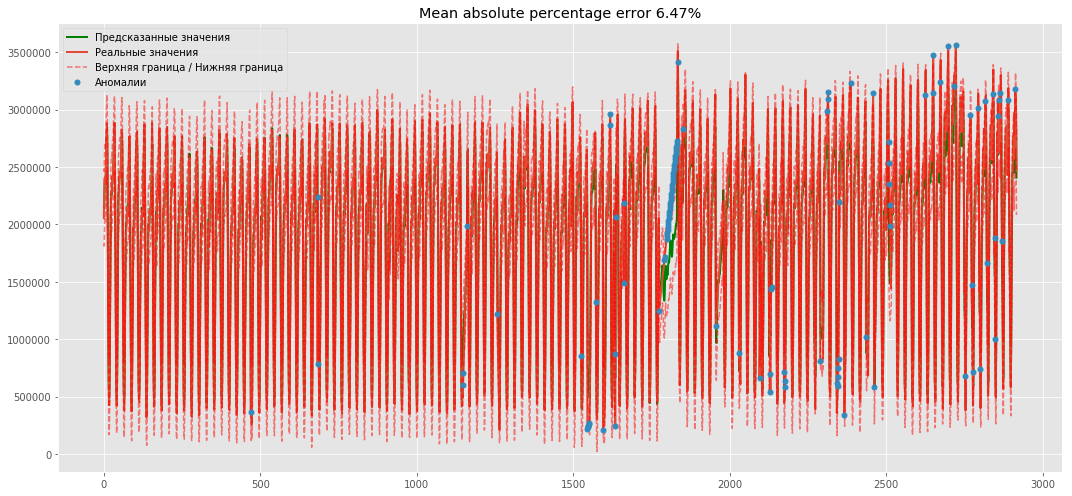

In [95]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True,scale = 2.5)
#plotCoefficients(lasso)


In [100]:
%%time
scale = 2.75
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)
prediction = lasso.predict(X_test_scaled)
cv = cross_val_score(lasso, X_train, y_train,cv=tscv, scoring="neg_mean_squared_error")
deviation = np.sqrt(cv.std()) # Стандартное отклонение
lower = prediction - (scale * deviation)
upper = prediction + (scale * deviation)  
anomalies = np.array([np.NaN]*len(y_test))
anomalies[y_test<lower] = y_test[y_test<lower]
anomalies[y_test>upper] = y_test[y_test>upper]
anomalies = pd.DataFrame(anomalies,y_test.index)

for scale in np.linspace(2.75,3,3):
    cv = cross_val_score(lasso, X_train, y_train,
                         cv=tscv, 
                         scoring="neg_mean_squared_error")
    deviation = np.sqrt(cv.std()) # Стандартное отклонение
    lower = prediction - (scale * deviation)
    upper = prediction + (scale * deviation)
    
    anomalies_lasso = np.array([np.NaN]*len(y_test))
    anomalies_lasso[y_test<lower] = y_test[y_test<lower]
    anomalies_lasso[y_test>upper] = y_test[y_test>upper]
    anomalies['{}'.format(scale)] = anomalies_lasso
anomalies.dropna(how = 'all',inplace=True)
anomalies['date'] = pd.to_datetime(anomalies.index, format='%Y-%m-%d %H:%M:%S')
anomalies['hour'] = anomalies['date'].dt.hour # час
anomalies['date'] = anomalies['date'].dt.strftime('%d.%m.%Y')    
#anomalies.to_csv('anomalies_lasso_ingush.csv')

CPU times: user 17.7 s, sys: 1min 10s, total: 1min 27s
Wall time: 3.21 s


In [101]:
anomalies

0         2.75        2.875          3.0  \
Дата со временем                                                          
2019-01-31 01:00:00  368097.4397  368097.4397  368097.4397  368097.4397   
2019-02-08 23:00:00  783212.0864  783212.0864  783212.0864  783212.0864   
2019-02-09 00:00:00 2242621.8050 2242621.8050 2242621.8050 2242621.8050   
2019-02-28 08:00:00  601401.1418  601401.1418          nan          nan   
2019-02-28 21:00:00 1984900.3874 1984900.3874 1984900.3874          nan   
2019-03-04 21:00:00 1224260.1995 1224260.1995 1224260.1995 1224260.1995   
2019-03-16 01:00:00  854109.9622  854109.9622  854109.9622  854109.9622   
2019-03-16 21:00:00  219296.7568  219296.7568  219296.7568  219296.7568   
2019-03-16 22:00:00  245478.0728  245478.0728  245478.0728  245478.0728   
2019-03-16 23:00:00  233228.9212  233228.9212  233228.9212  233228.9212   
2019-03-17 00:00:00  246516.4362  246516.4362  246516.4362  246516.4362   
2019-03-17 01:00:00  259803.9511  259803.9511  259803.9511  259803.9511   
2019-03-18 00:00:00 1327540.5949 1327540.5949 1327540.5949 1327540.5949   
2019-03-18 23:00:00  208380.5744  208380.5744  208380.5744  208380.5744   
2019-03-20 13:00:00  868280.9130  868280.9130          nan          nan   
2019-03-20 14:00:00  243605.2336  243605.2336          nan          nan   
2019-03-20 15:00:00 2066458.5664 2066458.5664 2066458.5664 2066458.5664   
2019-03-21 17:00:00 1491105.3901 1491105.3901 1491105.3901 1491105.3901   
2019-03-26 10:00:00 1246277.4841 1246277.4841 1246277.4841 1246277.4841   
2019-03-27 14:00:00 1975427.9763 1975427.9763          nan          nan   
2019-03-27 18:00:00 2079592.3323 2079592.3323          nan          nan   
2019-03-28 00:00:00 2235838.8664 2235838.8664 2235838.8664 2235838.8664   
2019-03-28 01:00:00 2261879.9554 2261879.9554 2261879.9554 2261879.9554   
2019-03-28 02:00:00 2287921.0444 2287921.0444 2287921.0444 2287921.0444   
2019-03-28 03:00:00 2313962.1334 2313962.1334 2313962.1334 2313962.1334   
2019-03-28 04:00:00 2340003.2224 2340003.2224 2340003.2224 2340003.2224   
2019-03-28 05:00:00 2366044.3114 2366044.3114 2366044.3114 2366044.3114   
2019-03-28 06:00:00 2392085.4004 2392085.4004 2392085.4004 2392085.4004   
2019-03-28 07:00:00 2418126.4894 2418126.4894 2418126.4894 2418126.4894   
2019-03-28 08:00:00 2444167.5784 2444167.5784 2444167.5784 2444167.5784   
...                          ...          ...          ...          ...   
2019-03-28 19:00:00 2730619.5575 2730619.5575 2730619.5575 2730619.5575   
2019-03-28 21:00:00 3413140.6707 3413140.6707 3413140.6707 3413140.6707   
2019-04-02 23:00:00 1112324.9196 1112324.9196 1112324.9196 1112324.9196   
2019-04-06 01:00:00  881885.8540  881885.8540  881885.8540  881885.8540   
2019-04-08 19:00:00  660514.1336  660514.1336  660514.1336  660514.1336   
2019-04-10 06:00:00  538451.2463  538451.2463  538451.2463  538451.2463   
2019-04-10 09:00:00 1439640.7354 1439640.7354 1439640.7354          nan   
2019-04-12 01:00:00  717579.5453  717579.5453  717579.5453          nan   
2019-04-16 21:00:00  806996.2103  806996.2103  806996.2103  806996.2103   
2019-04-19 01:00:00  622911.5198  622911.5198  622911.5198  622911.5198   
2019-04-19 06:00:00  668330.9366  668330.9366  668330.9366          nan   
2019-04-19 07:00:00  746250.3148  746250.3148  746250.3148  746250.3148   
2019-04-19 08:00:00  824169.6930  824169.6930  824169.6930  824169.6930   
2019-04-19 09:00:00 2194426.9385 2194426.9385 2194426.9385 2194426.9385   
2019-04-20 02:00:00  336861.9280  336861.9280          nan          nan   
2019-04-22 23:00:00 1020650.9506 1020650.9506 1020650.9506 1020650.9506   
2019-04-23 22:00:00 3146335.5253 3146335.5253          nan          nan   
2019-04-24 01:00:00  586171.6965  586171.6965  586171.6965  586171.6965   
2019-04-26 00:00:00 2716284.8749 2716284.8749 2716284.8749 2716284.8749   
2019-04-26 01:00:00 2534427.1164 2534427.1164 2534427.1164 2534427.1164   
2019-04-26 02:00:00 2352569.3580 2352569.3580 2352569.35

#### XGb-регрессия

In [104]:
# оставляем 30% от данных для тестирования
#X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)
X_train, X_test, y_train, y_test =\
prepareData(df_model, lag_start=1, lag_end=25, test_size=0.3, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

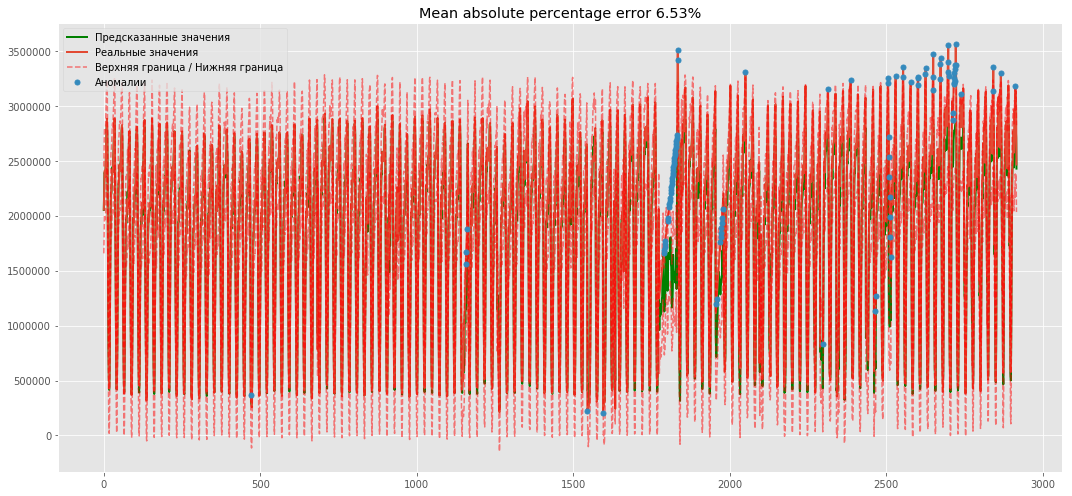

In [114]:
plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True,scale = 4.5)

In [119]:
%%time
scale = 4.5
prediction = xgb.predict(X_test_scaled)
cv = cross_val_score(xgb, X_train, y_train,cv=tscv, scoring="neg_mean_squared_error")
deviation = np.sqrt(cv.std()) # Стандартное отклонение
lower = prediction - (scale * deviation)
upper = prediction + (scale * deviation)  
anomalies = np.array([np.NaN]*len(y_test))
anomalies[y_test<lower] = y_test[y_test<lower]
anomalies[y_test>upper] = y_test[y_test>upper]
anomalies = pd.DataFrame(anomalies,y_test.index)

for scale in np.linspace(4.5,5.5,5):
    cv = cross_val_score(xgb, X_train, y_train,
                         cv=tscv, 
                         scoring="neg_mean_squared_error")
    deviation = np.sqrt(cv.std()) # Стандартное отклонение
    lower = prediction - (scale * deviation)
    upper = prediction + (scale * deviation)
    
    anomalies_xgb = np.array([np.NaN]*len(y_test))
    anomalies_xgb[y_test<lower] = y_test[y_test<lower]
    anomalies_xgb[y_test>upper] = y_test[y_test>upper]
    anomalies['{}'.format(scale)] = anomalies_xgb
anomalies.dropna(how = 'all',inplace=True)
anomalies['date'] = pd.to_datetime(anomalies.index, format='%Y-%m-%d %H:%M:%S')
anomalies['hour'] = anomalies['date'].dt.hour # час
anomalies['date'] = anomalies['date'].dt.strftime('%d.%m.%Y') 
#anomalies.to_csv('anomalies_xgb_ingush.csv')

CPU times: user 23.4 s, sys: 222 ms, total: 23.6 s
Wall time: 23.6 s


In [120]:
anomalies

0          4.5         4.75          5.0  \
Дата со временем                                                          
2019-01-31 01:00:00  368097.4397  368097.4397  368097.4397  368097.4397   
2019-02-28 17:00:00 1559208.3118 1559208.3118          nan          nan   
2019-02-28 18:00:00 1665631.3307 1665631.3307 1665631.3307 1665631.3307   
2019-02-28 20:00:00 1878477.3685 1878477.3685 1878477.3685 1878477.3685   
2019-03-16 21:00:00  219296.7568  219296.7568  219296.7568  219296.7568   
2019-03-18 23:00:00  208380.5744  208380.5744  208380.5744  208380.5744   
2019-03-27 02:00:00 1662934.9082 1662934.9082 1662934.9082 1662934.9082   
2019-03-27 03:00:00 1688975.9972 1688975.9972 1688975.9972 1688975.9972   
2019-03-27 04:00:00 1715017.0862 1715017.0862 1715017.0862 1715017.0862   
2019-03-27 05:00:00 1741058.1752 1741058.1752 1741058.1752 1741058.1752   
2019-03-27 06:00:00 1767099.2642 1767099.2642 1767099.2642 1767099.2642   
2019-03-27 13:00:00 1949386.8873 1949386.8873 1949386.8873 1949386.8873   
2019-03-27 14:00:00 1975427.9763 1975427.9763 1975427.9763 1975427.9763   
2019-03-27 18:00:00 2079592.3323 2079592.3323 2079592.3323 2079592.3323   
2019-03-27 19:00:00 2105633.4213 2105633.4213 2105633.4213 2105633.4213   
2019-03-27 20:00:00 2131674.5103 2131674.5103 2131674.5103 2131674.5103   
2019-03-27 21:00:00 2157715.5994 2157715.5994 2157715.5994          nan   
2019-03-27 23:00:00 2209797.7774 2209797.7774          nan          nan   
2019-03-28 00:00:00 2235838.8664 2235838.8664 2235838.8664 2235838.8664   
2019-03-28 01:00:00 2261879.9554 2261879.9554 2261879.9554 2261879.9554   
2019-03-28 02:00:00 2287921.0444 2287921.0444 2287921.0444 2287921.0444   
2019-03-28 03:00:00 2313962.1334 2313962.1334 2313962.1334 2313962.1334   
2019-03-28 04:00:00 2340003.2224 2340003.2224 2340003.2224 2340003.2224   
2019-03-28 05:00:00 2366044.3114 2366044.3114 2366044.3114 2366044.3114   
2019-03-28 06:00:00 2392085.4004 2392085.4004 2392085.4004 2392085.4004   
2019-03-28 07:00:00 2418126.4894 2418126.4894 2418126.4894 2418126.4894   
2019-03-28 08:00:00 2444167.5784 2444167.5784 2444167.5784 2444167.5784   
2019-03-28 09:00:00 2470208.6674 2470208.6674 2470208.6674 2470208.6674   
2019-03-28 10:00:00 2496249.7565 2496249.7565 2496249.7565 2496249.7565   
2019-03-28 11:00:00 2522290.8455 2522290.8455 2522290.8455 2522290.8455   
...                          ...          ...          ...          ...   
2019-04-29 21:00:00 3258292.1778 3258292.1778          nan          nan   
2019-04-29 22:00:00 3255883.5763 3255883.5763 3255883.5763          nan   
2019-04-30 21:00:00 3291994.8214 3291994.8214 3291994.8214 3291994.8214   
2019-04-30 22:00:00 3347645.2509 3347645.2509 3347645.2509 3347645.2509   
2019-05-01 20:00:00 3141079.6009 3141079.6009          nan          nan   
2019-05-01 21:00:00 3263870.1999 3263870.1999 3263870.1999 3263870.1999   
2019-05-01 22:00:00 3472919.8915 3472919.8915 3472919.8915 3472919.8915   
2019-05-02 20:00:00 3242673.2466 3242673.2466 3242673.2466 3242673.2466   
2019-05-02 21:00:00 3383155.9047 3383155.9047 3383155.9047 3383155.9047   
2019-05-02 22:00:00 3432713.0592 3432713.0592 3432713.0592 3432713.0592   
2019-05-03 20:00:00 3307858.1777 3307858.1777 3307858.1777 3307858.1777   
2019-05-03 21:00:00 3402941.3118 3402941.3118 3402941.3118 3402941.3118   
2019-05-03 22:00:00 3553750.0147 3553750.0147 3553750.0147 3553750.0147   
2019-05-03 23:00:00 3269039.5986 3269039.5986 3269039.5986          nan   
2019-05-04 13:00:00 2872100.5281 2872100.5281 2872100.5281          nan   
2019-05-04 14:00:00 2933939.5432 2933939.5432 2933939.5432          nan   
2019-05-04 15:00:00 3208241.0741 3208241.0741 3208241.0741 3208241.0741   
2019-05-04 16:00:00 3201413.7377 3201413.7377 3201413.7377 3201413.7377   
2019-05-04 17:00:00 3254434.3545 3254434.3545 3254434.3545 3254434.3545   
2019-05-04 18:00:00 3296070.5764 3296070.5764 3296070.5764 3296070.5764   
2019-05-04 19:00:00 3224290.7596 3224290.7596 3224290.75